In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from allenAnalysis.utils import *

import bluepysnap as bp
%matplotlib ipympl

In [2]:
from allenAnalysis.icsd import StandardCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
path_to_simulation = '../hippocampusSim/'

In [6]:
s = bp.Simulation(path_to_simulation+'simulation_config_big.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    for iteration in range(numIter):
        p = pd.read_pickle('../hippocampusSim/pkls_big/eeg_'+t+'_'+str(iteration)+'.pkl')
        if iteration == 0:
            s = p
        else:
            s += p
        
    signals.append(s)

totalSignal = 0
for s in signals:
    totalSignal += s


In [37]:


s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals_small = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    p = pd.read_pickle('../hippocampusSim/pkls/eeg_'+t+'.pkl')
        
    signals_small.append(p)

totalSignal_small = 0
for s in signals_small:
    totalSignal_small += s

In [31]:
lfpIdx = np.arange(11)

In [38]:
totalLFP = totalSignal[lfpIdx]
totalLFP_small = totalSignal_small[lfpIdx]


In [11]:
import h5py
f = h5py.File('../electrodeFile/coeffs_big.h5')


In [15]:
f['electrodes']['0'].keys()

<KeysViewHDF5 ['hippocampus_neurons', 'layer', 'position', 'region', 'type']>

In [17]:
electrodePos = []
for e in np.arange(11):
    electrodePos.append(f['electrodes'][str(e)]['position'][:])
    
electrodePos = np.array(electrodePos)

In [18]:
np.linalg.norm(electrodePos[1]-electrodePos[0])

91.91300234460844

In [19]:
f.close()

In [33]:
meanLfp = np.mean(totalLFP,axis=0)

In [34]:
totalLFP -= meanLfp

In [23]:
time = np.arange(0,20000,1)

In [51]:
def plotFig(ax,csd,absmax=None):


    if absmax is None:
        absmax = np.max(np.abs(csd))/2
        plotCB = True
    else:
        plotCB = False
    
    im = ax.imshow(np.array(csd), origin='lower', vmin =-absmax,vmax=absmax, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_xlim([11000,12000])

    
    
        

In [44]:
csd

array([[ 0.        ,  0.0058046 ,  0.0074941 , ...,  0.00551813,
         0.00574382,  0.00583783],
       [ 0.        ,  0.01204477,  0.01354007, ...,  0.00942265,
         0.00989471,  0.01042239],
       [ 0.        , -0.00512094, -0.00659131, ..., -0.00600705,
        -0.00617048, -0.00609803],
       ...,
       [ 0.        ,  0.00470805,  0.00683903, ...,  0.00677345,
         0.00710877,  0.00739649],
       [ 0.        ,  0.00088286,  0.00168569, ...,  0.00160843,
         0.0016679 ,  0.00178372],
       [ 0.        , -0.00188899, -0.00239061, ..., -0.00251715,
        -0.00265143, -0.00271118]]) * A/m**2

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


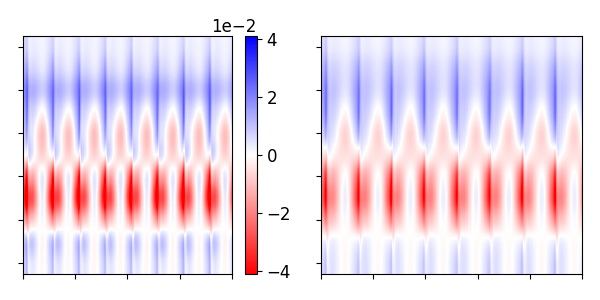

In [52]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(1,2,figsize=(6,3))

lfp_data = totalLFP.values.T * 1E-3 * pq.V        # [mV] -> [V]
lfp_data_small = totalLFP_small.values.T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(0,51) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 20E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

std_input_small = {
    'lfp' : lfp_data_small,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

std_csd = StandardCSD(**std_input)
std_csd_small = StandardCSD(**std_input_small)


    
csd = std_csd.get_csd()
csd = std_csd.filter_csd(csd)

plotFig(axes[0],csd)
# ax.set_title('iCSD')

csdsmall = std_csd_small.get_csd()
csdsmall = std_csd_small.filter_csd(csd)

plotFig(axes[1],csdsmall,np.max(np.abs(csd))/2)
# ax.set_title('iCSD')



plt.tight_layout()
plt.show()


